Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_96 (Conv2D)          (None, 16, 16, 32)           320       ['input_49[0][0]']            
                                                                                                  
 conv2d_97 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_96[0][0]']           
                                                                                                  
 conv2d_98 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_97[0][0]']           
                                                                                           

2023-07-23 10:44:51.257735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


600/600 [==============================] - 9s 14ms/step - total_loss: 302.8853 - reconstruction_loss: 298.0695 - kl_loss: 4.8159
Epoch 2/10
600/600 [==============================] - 8s 13ms/step - total_loss: 263.1489 - reconstruction_loss: 257.8963 - kl_loss: 5.2527
Epoch 3/10
600/600 [==============================] - 8s 13ms/step - total_loss: 260.4771 - reconstruction_loss: 255.2119 - kl_loss: 5.2652
Epoch 4/10
600/600 [==============================] - 8s 13ms/step - total_loss: 259.0375 - reconstruction_loss: 253.7378 - kl_loss: 5.2997
Epoch 5/10
600/600 [==============================] - 8s 13ms/step - total_loss: 257.9760 - reconstruction_loss: 252.6567 - kl_loss: 5.3192
Epoch 6/10
600/600 [==============================] - 8s 13ms/step - total_loss: 257.4427 - reconstruction_loss: 252.1092 - kl_loss: 5.3335
Epoch 7/10
600/600 [==============================] - 8s 13ms/step - total_loss: 256.6391 - reconstruction_loss: 251.2738 - kl_loss: 5.3652
Epoch 8/10
600/600 [===========

2023-07-23 10:46:12.200022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 54/157 [=========>....................] - ETA: 0s

2023-07-23 10:46:13.584695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 0s 2ms/step


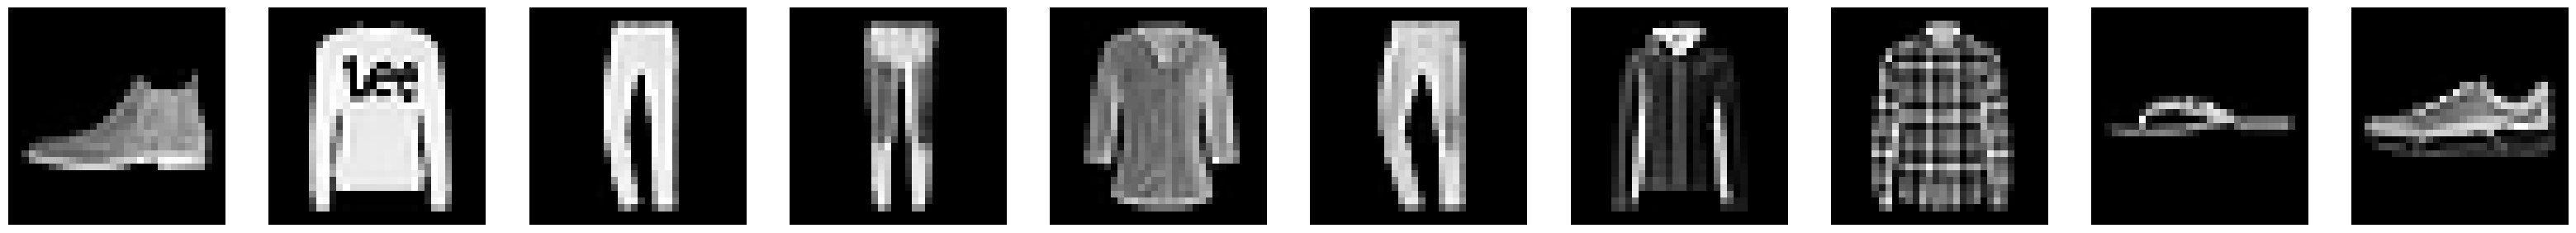

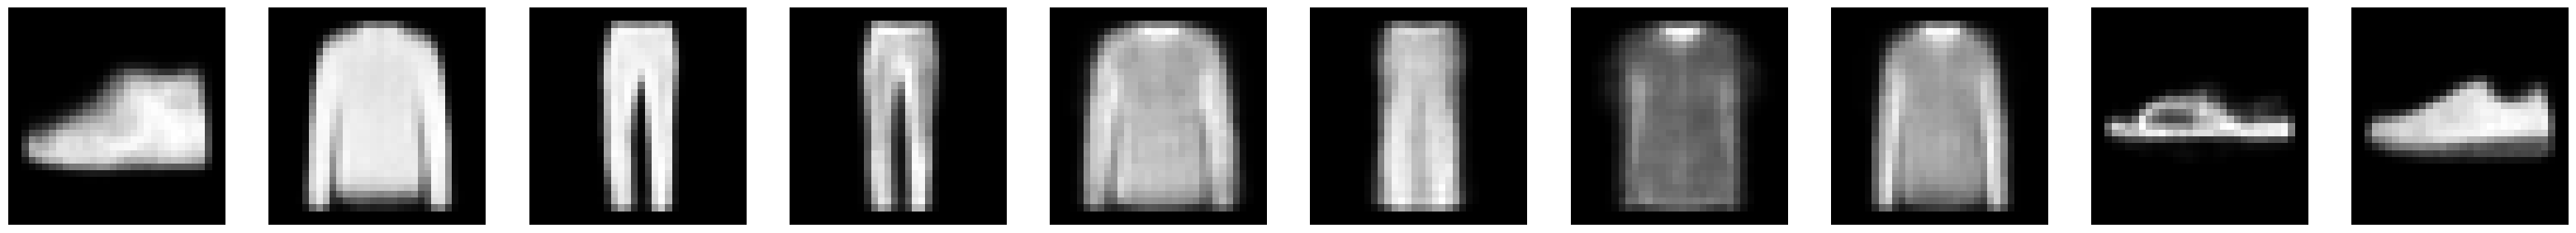

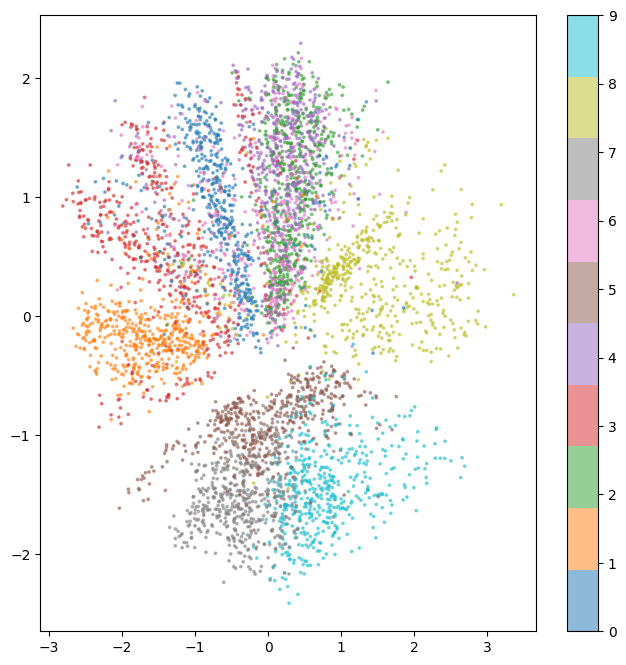

1/1 [==============================] - 0s 100ms/step


2023-07-23 10:46:14.407766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


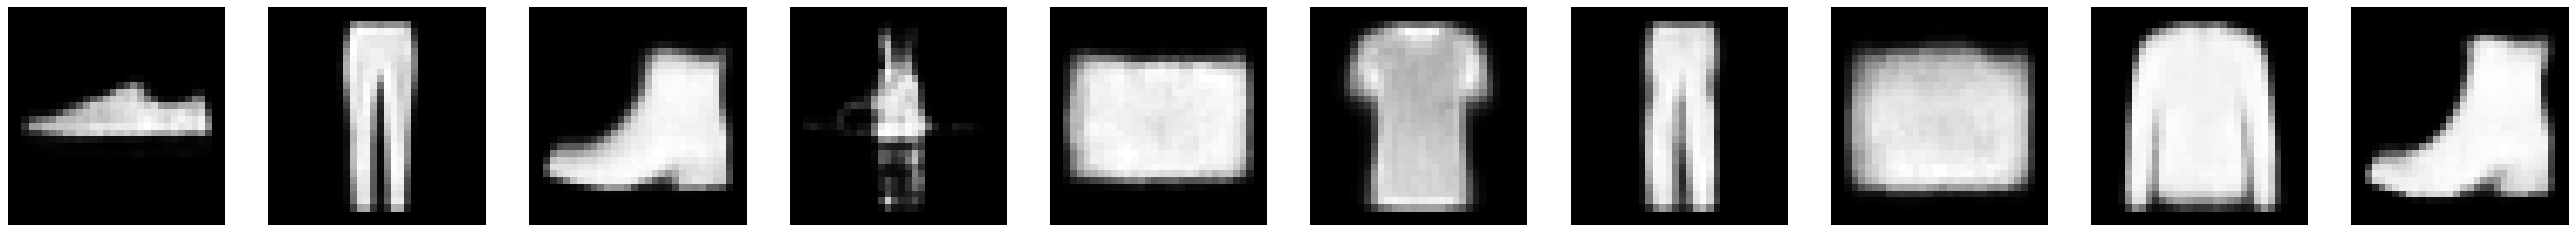

In [25]:
from json import decoder
import numpy as np
from keras import datasets, utils, layers, models, optimizers
import keras
import matplotlib.pyplot as plt
import tensorflow

LOAD_FROM_FILE = False
EMBEDDING_DIM = 2

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = keras.backend.random_normal(shape=keras.backend.shape(z_mean))
        return z_mean + keras.backend.exp(z_log_var / 2) * epsilon
      
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tensorflow.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction) * 1000
            reconstruction_loss = tensorflow.reduce_mean(reconstruction_loss)
            # reconstruction_loss *= 1e-6

            kl_loss = 1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var)
            kl_loss = keras.backend.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            'total_loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

def preprocess(imgs):
    imgs = imgs.astype('float32') / 255
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), 'constant')
    imgs = np.expand_dims(imgs, axis=-1) # this is to add a channel dimension
    return imgs

# tensorflow.config.set_visible_devices([], 'GPU')

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# if not LOAD_FROM_FILE:
# Encoder
input_layer = layers.Input(shape=(32, 32, 1))

x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(input_layer)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
# x = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)

shape_before_flattening = keras.backend.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(units=EMBEDDING_DIM)(x)
z_log_var = layers.Dense(units=EMBEDDING_DIM)(x)
z = Sampling()([z_mean, z_log_var])
  
encoder = models.Model(inputs=input_layer, outputs=[z_mean, z_log_var, z])

encoder.summary()

# Decoder
input_layer = layers.Input(shape=(EMBEDDING_DIM,))
x = layers.Dense(units=np.prod(shape_before_flattening), activation='relu')(input_layer)
x = layers.Reshape(target_shape=shape_before_flattening)(x)

# x = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)

decoder_output = layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')(x)

decoder = models.Model(inputs=input_layer, outputs=decoder_output)

# VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=10, batch_size=100)

# Plotting
example_imgs = x_test[:5000]
z_mean, z_log_var, reconstructions = vae.predict(example_imgs)

fig = plt.figure(figsize=(40, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(example_imgs[i, :, :, 0], cmap='gray')
    plt.axis('off')

fig = plt.figure(figsize=(40, 10))
for i in range(10):
    plt.subplot(1, 10,  i + 1)
    plt.imshow(reconstructions[i, :, :, 0], cmap='gray')
    plt.axis('off')
    
# Visualizing the latent space
z_mean, z_log_var, z = encoder.predict(example_imgs)
plt.figure(figsize=(8, 8))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test[:5000], cmap='tab10', alpha=0.5, s=3)
plt.colorbar()
plt.show()

# Generating new images
mins, maxs = z.min(axis=0), z.max(axis=0)
sample = np.random.rand(18, EMBEDDING_DIM) * (maxs - mins) + mins
reconstructions = decoder.predict(sample)

fig = plt.figure(figsize=(40, 10))
for i in range(10):
    plt.subplot(1, 10,  i + 1)
    plt.imshow(reconstructions[i, :, :, 0], cmap='gray')
    plt.axis('off')
